<a href="https://colab.research.google.com/github/erandime/Customer-Churn-Prediction/blob/main/Customer_Churn_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## 1. Importing Dependencies

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2,mutual_info_classif
from sklearn.feature_selection import f_classif
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import pickle
from collections import Counter
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import chi2_contingency

## 2. Data Loading and Initial Exploration

In [3]:
df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/WA_Fn-UseC_-Telco-Customer-Churn.csv")
pd.set_option("display.max_columns", None)
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [4]:
df.shape

(7043, 21)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [6]:
print(df.isnull().sum())

customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64


## 3. Data Preprocessing

In [7]:
# Drop customerID column as it is an identifier and not used for modeling
df = df.drop(columns=["customerID"])
df.head(2)

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No


In [8]:
#Convert datatype of TotalCharges from object to float
#df["TotalCharges"] = df["TotalCharges"].astype(float)

* Above gives an error as some rows contain blank strings instead of numeric values

In [9]:
df[df["TotalCharges"]==" "]

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
488,Female,0,Yes,Yes,0,No,No phone service,DSL,Yes,No,Yes,Yes,Yes,No,Two year,Yes,Bank transfer (automatic),52.55,,No
753,Male,0,No,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.25,,No
936,Female,0,Yes,Yes,0,Yes,No,DSL,Yes,Yes,Yes,No,Yes,Yes,Two year,No,Mailed check,80.85,,No
1082,Male,0,Yes,Yes,0,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.75,,No
1340,Female,0,Yes,Yes,0,No,No phone service,DSL,Yes,Yes,Yes,Yes,Yes,No,Two year,No,Credit card (automatic),56.05,,No
3331,Male,0,Yes,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,19.85,,No
3826,Male,0,Yes,Yes,0,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.35,,No
4380,Female,0,Yes,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.00,,No
5218,Male,0,Yes,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,One year,Yes,Mailed check,19.70,,No
6670,Female,0,Yes,Yes,0,Yes,Yes,DSL,No,Yes,Yes,Yes,Yes,No,Two year,No,Mailed check,73.35,,No


In [10]:
len(df[df["TotalCharges"]==" "])

11

In [11]:
# Replace blank strings in TotalCharges with '0.0' as blank strings correspond to customers with 0 Tenure.
#That is for new customers current Total Charge is 0.
df["TotalCharges"] = df["TotalCharges"].replace({" ": "0.0"})

In [12]:
# Convert to float after cleaning
df["TotalCharges"] = df["TotalCharges"].astype(float)

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            7043 non-null   object 
 1   SeniorCitizen     7043 non-null   int64  
 2   Partner           7043 non-null   object 
 3   Dependents        7043 non-null   object 
 4   tenure            7043 non-null   int64  
 5   PhoneService      7043 non-null   object 
 6   MultipleLines     7043 non-null   object 
 7   InternetService   7043 non-null   object 
 8   OnlineSecurity    7043 non-null   object 
 9   OnlineBackup      7043 non-null   object 
 10  DeviceProtection  7043 non-null   object 
 11  TechSupport       7043 non-null   object 
 12  StreamingTV       7043 non-null   object 
 13  StreamingMovies   7043 non-null   object 
 14  Contract          7043 non-null   object 
 15  PaperlessBilling  7043 non-null   object 
 16  PaymentMethod     7043 non-null   object 


In [14]:
# Convert SeniorCitizen from 0/1 to 'No'/'Yes' for consistency with other binary columns
df["SeniorCitizen"]= df["SeniorCitizen"].map({0: "No", 1: "Yes"})
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            7043 non-null   object 
 1   SeniorCitizen     7043 non-null   object 
 2   Partner           7043 non-null   object 
 3   Dependents        7043 non-null   object 
 4   tenure            7043 non-null   int64  
 5   PhoneService      7043 non-null   object 
 6   MultipleLines     7043 non-null   object 
 7   InternetService   7043 non-null   object 
 8   OnlineSecurity    7043 non-null   object 
 9   OnlineBackup      7043 non-null   object 
 10  DeviceProtection  7043 non-null   object 
 11  TechSupport       7043 non-null   object 
 12  StreamingTV       7043 non-null   object 
 13  StreamingMovies   7043 non-null   object 
 14  Contract          7043 non-null   object 
 15  PaperlessBilling  7043 non-null   object 
 16  PaymentMethod     7043 non-null   object 


In [15]:
# Define numeric columns to skip when exploring categorical values
numerical_cols = ["tenure", "MonthlyCharges", "TotalCharges"]

# Print unique values of each categorical column
for col in df.columns:
  if col not in numerical_cols:
    print(col, df[col].unique())
    print("-"*50)

gender ['Female' 'Male']
--------------------------------------------------
SeniorCitizen ['No' 'Yes']
--------------------------------------------------
Partner ['Yes' 'No']
--------------------------------------------------
Dependents ['No' 'Yes']
--------------------------------------------------
PhoneService ['No' 'Yes']
--------------------------------------------------
MultipleLines ['No phone service' 'No' 'Yes']
--------------------------------------------------
InternetService ['DSL' 'Fiber optic' 'No']
--------------------------------------------------
OnlineSecurity ['No' 'Yes' 'No internet service']
--------------------------------------------------
OnlineBackup ['Yes' 'No' 'No internet service']
--------------------------------------------------
DeviceProtection ['No' 'Yes' 'No internet service']
--------------------------------------------------
TechSupport ['No' 'Yes' 'No internet service']
--------------------------------------------------
StreamingTV ['No' 'Yes' 'No in

In [16]:
# Clean categorical values: merge 'No internet service' and 'No phone service' into 'No'
cols_to_clean = [
    'MultipleLines',
    'OnlineSecurity',
    'OnlineBackup',
    'DeviceProtection',
    'TechSupport',
    'StreamingTV',
    'StreamingMovies'
]

for col in cols_to_clean:
    df[col] = df[col].replace({'No internet service': 'No', 'No phone service': 'No'})


In [17]:
for col in df.columns:
  if col not in numerical_cols:
    print(col, df[col].unique())
    print("-"*50)

gender ['Female' 'Male']
--------------------------------------------------
SeniorCitizen ['No' 'Yes']
--------------------------------------------------
Partner ['Yes' 'No']
--------------------------------------------------
Dependents ['No' 'Yes']
--------------------------------------------------
PhoneService ['No' 'Yes']
--------------------------------------------------
MultipleLines ['No' 'Yes']
--------------------------------------------------
InternetService ['DSL' 'Fiber optic' 'No']
--------------------------------------------------
OnlineSecurity ['No' 'Yes']
--------------------------------------------------
OnlineBackup ['Yes' 'No']
--------------------------------------------------
DeviceProtection ['No' 'Yes']
--------------------------------------------------
TechSupport ['No' 'Yes']
--------------------------------------------------
StreamingTV ['No' 'Yes']
--------------------------------------------------
StreamingMovies ['No' 'Yes']
--------------------------------

## 4. Exploratory Data Analysis (EDA)

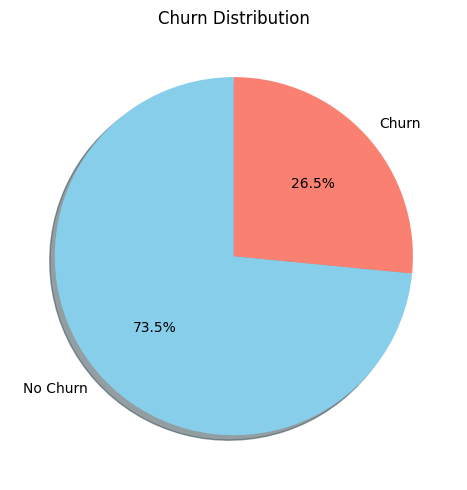

In [18]:
# Check the class distribution of the target variable 'Churn'
churn_counts = df["Churn"].value_counts()

# Plot pie chart
plt.figure(figsize=(5, 5))
churn_counts.plot.pie(
    autopct='%1.1f%%',
    startangle=90,
    labels=['No Churn', 'Churn'],  # Only works if 0/1 encoded
    colors=['skyblue', 'salmon'],
    shadow=True
)
plt.title('Churn Distribution')
plt.ylabel('')  # Removes y-axis label
plt.tight_layout()
plt.show()

* The target variable Churn is imbalanced.
* Predictive models may favor the majority class (non-churned), resulting in high accuracy but poor recall for churned customers.
* Evaluation metrics like F1-score, precision, and recall should be prioritized over plain accuracy.
* The imbalance should be handled using model-specific weighting techniques.



### 4.1 Analysis of Numerical Variables

In [19]:
numerical_cols = ['tenure', 'MonthlyCharges', 'TotalCharges']

#Summary statistics for numerical features
df[numerical_cols].describe().T

,count,mean,std,min,25%,50%,75%,max
tenure,7043.0,32.371149,24.559481,0.00,9.00,29.00,55.00,72.00
MonthlyCharges,7043.0,64.761692,30.090047,18.25,35.50,70.35,89.85,118.75
TotalCharges,7043.0,2279.734304,2266.794470,0.00,398.55,1394.55,3786.60,8684.80


In [20]:
#Histogram Plot Function
def plot_histogram(df, column_name):
    plt.figure(figsize=(5, 3))
    sns.histplot(df[column_name], kde=True)
    plt.title(f"Distribution of {column_name}")
    plt.axvline(df[column_name].mean(), color="red", linestyle="--", label="Mean")
    plt.axvline(df[column_name].median(), color="green", linestyle="-", label="Median")
    plt.legend()
    plt.show()

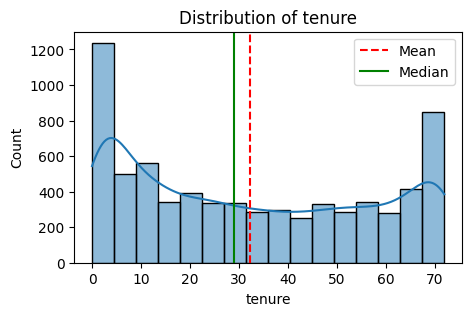

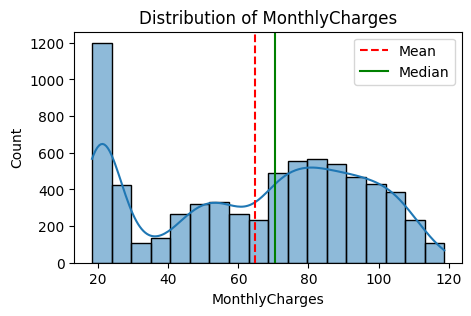

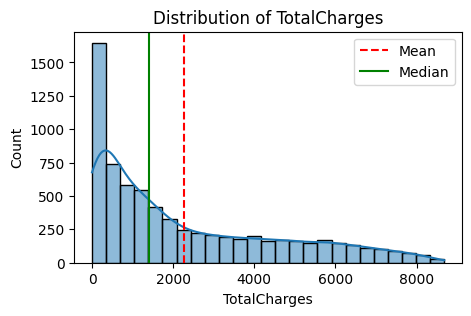

In [34]:
plot_histogram(df, "tenure")
plot_histogram(df, "MonthlyCharges")
plot_histogram(df, "TotalCharges")



* Tenure shows a bimodal distribution, with peaks among short- and long-term customers, suggesting that customers tend to either leave early or stay long-term.
* Monthly charges have a multimodal distribution, indicating that pricing plans or add-on services likely group customers into distinct pricing tiers.
* Total charges are right-skewed with a long tail, reflecting a few high-value long-term customers, while most have lower charges due to shorter tenure.



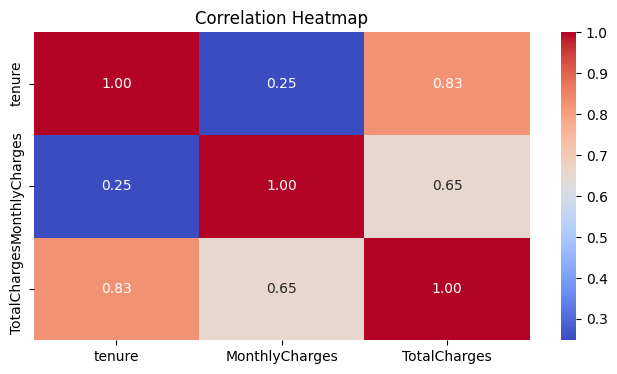

In [35]:
#Correlation Heatmap
plt.figure(figsize=(8, 4))
sns.heatmap(df[["tenure", "MonthlyCharges", "TotalCharges"]].corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap")
plt.show()

* Tenure & TotalCharges - 0.83 - Strong positive correlation. Customers naturally accumulate more charges the longer they stay.
* MonthlyCharges & TotalCharges - 0.65	- Moderate correlation. Higher monthly charges generally lead to higher totals, but tenure is also a key factor.
* Tenure & MonthlyCharges	- 0.25 - Weak positive correlation. Monthly cost doesn’t rise much with tenure, suggesting it's driven more by service choices than customer duration.
* Insight: Tenure is the strongest driver of total charges. Monthly charges are more influenced by selected services than by how long the customer stays.




In [36]:
# Compare mean of numerical features by Churn status
df.groupby('Churn').mean(numerical_cols)

,tenure,MonthlyCharges,TotalCharges
Churn,,,
No,37.569965,61.265124,2549.911442
Yes,17.979133,74.441332,1531.796094


* Churned customers have lower average tenure, indicating they are generally newer customers.
* Churned customers have slightly higher monthly charges than non-churned customers.
* Churned customers have lower total charges, because they've been with the company for a shorter time.
* Overall, customers who churn are typically new and pay more per month, but haven’t stayed long enough to accumulate high total charges.

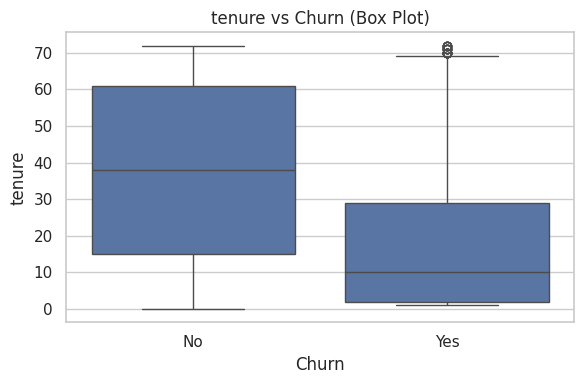

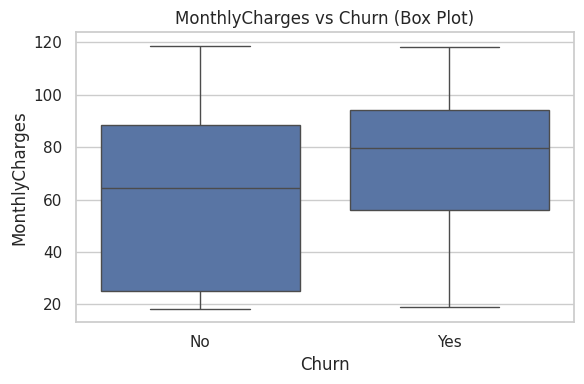

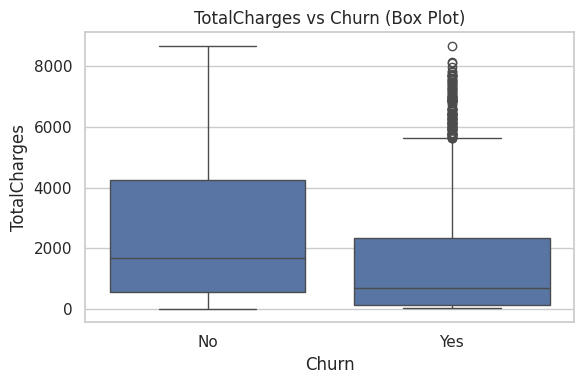

In [37]:
#Boxplots by Churn (Numerical vs Target)
sns.set(style="whitegrid")
for col in numerical_cols:
    plt.figure(figsize=(6, 4))
    sns.boxplot(data=df, x='Churn', y=col)
    plt.title(f'{col} vs Churn (Box Plot)')
    plt.tight_layout()
    plt.show()



*   Tenure by Churn -
Churned customers have significantly lower tenure, with more outliers among long-term stayers.
Insight: Long-term customers are less likely to churn. Tenure is a strong predictor of retention.
*   Monthly Charges by Churn -
Churned customers tend to have higher monthly charges on average.
Insight: High monthly costs may contribute to churn, especially for newer customers who haven’t yet seen long-term value.
* Total Charges by Churn -
Churned customers have much lower total charges.
Insight: Since total charges reflect how long a customer has been with the company, lower totals among churned customers further support that they tend to leave early in their lifecycle.
* Since TotalCharges is mostly explained by tenure × MonthlyCharges, including it may lead to redundancy and multicollinearity in logistic regression.



### 4.2. Analysis of Categorical Variables

In [39]:
#Stacked Bar Charts — Churn vs Categorical Variables
# Define groups of related categorical variables
groups = {
    "Customer Demographics": ['gender', 'SeniorCitizen', 'Partner', 'Dependents'],
    "Service Subscriptions": ['PhoneService', 'MultipleLines', 'InternetService', 'StreamingTV', 'StreamingMovies'],
    "Security & Support": ['OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport'],
    "Contract & Billing": ['Contract', 'PaperlessBilling', 'PaymentMethod']
}

# Reuse the plotting function
def plot_group_churn_stacked(group_name, cols, df):
    rows = (len(cols) + 1) // 2
    fig, axes = plt.subplots(rows, 2, figsize=(12, 4 * rows))
    axes = axes.flatten()

    for i, col in enumerate(cols):
        ax = axes[i]
        grouped = df.groupby([col, 'Churn']).size().unstack(fill_value=0)
        grouped = grouped.div(grouped.sum(axis=1), axis=0)

        grouped.plot(kind='bar', stacked=True, ax=ax, colormap='Set2', legend=False)
        ax.set_title(f'{col}')
        ax.set_ylabel('Proportion')
        ax.set_xticklabels(ax.get_xticklabels(), rotation=45)

        for bar_idx, category in enumerate(grouped.index):
            cumulative = 0
            for churn_class in grouped.columns:
                height = grouped.loc[category, churn_class]
                if height > 0:
                    ax.text(bar_idx, cumulative + height / 2, f'{height:.0%}',
                            ha='center', va='center', fontsize=8)
                    cumulative += height

    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    fig.suptitle(f'{group_name} - Churn Breakdown', fontsize=16)
    fig.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()


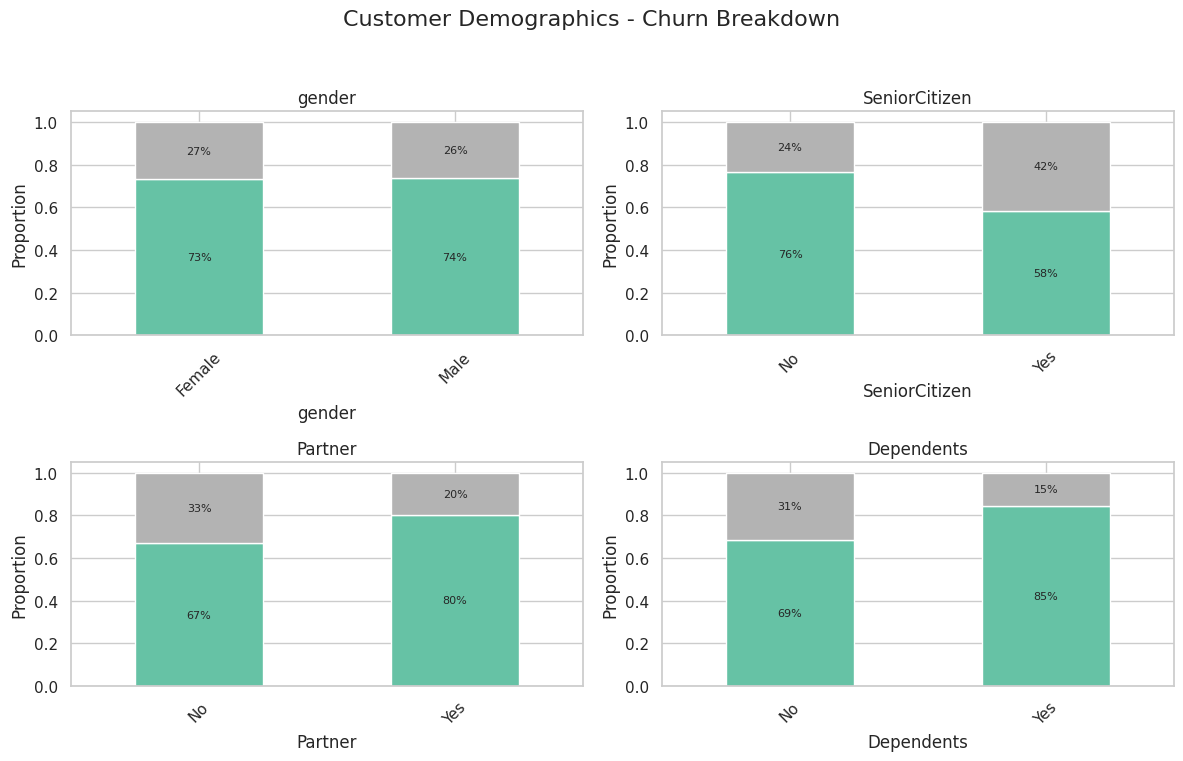

In [40]:
plot_group_churn_stacked("Customer Demographics", groups["Customer Demographics"], df)

* Churn is higher among customers who are:
Senior Citizens /
Without partners /
Without dependents.
* Minimal difference in churn rate by gender.
* Summary: Non-family, senior users are at higher churn risk.

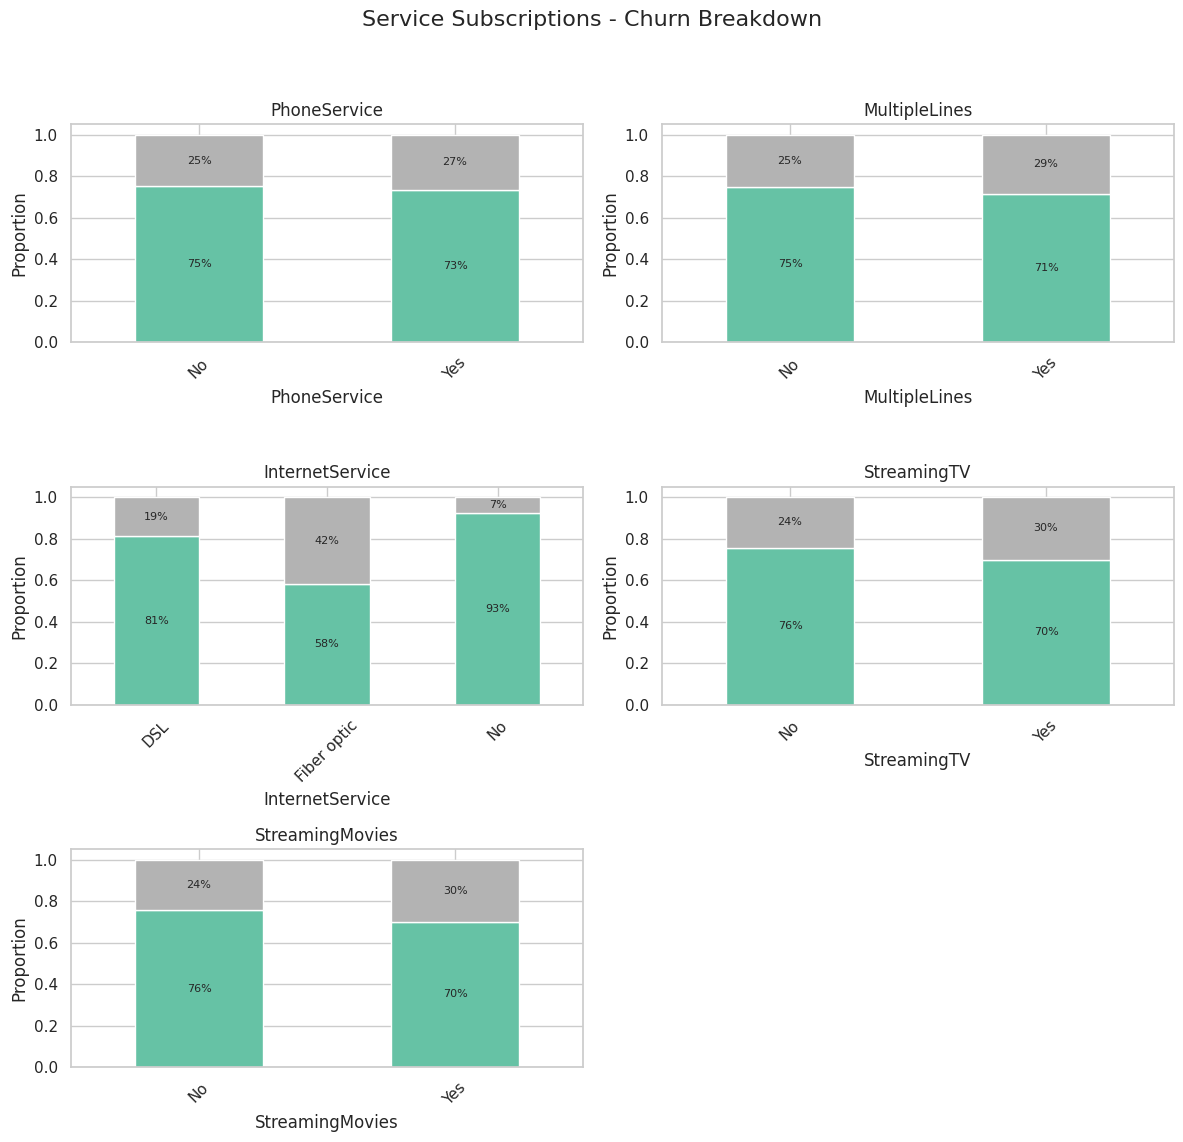

In [41]:
plot_group_churn_stacked("Service Subscriptions", groups["Service Subscriptions"], df)

* Fiber optic users churn the most.
* Slightly more churn with phone service.
* Slightly higher churn among users with multiple lines.
* Streaming users churn a bit more.
* Summary: Customers with more complex or premium subscriptions (fiber internet, multiple lines, streaming) are at higher churn risk due to higher costs or unmet expectations.

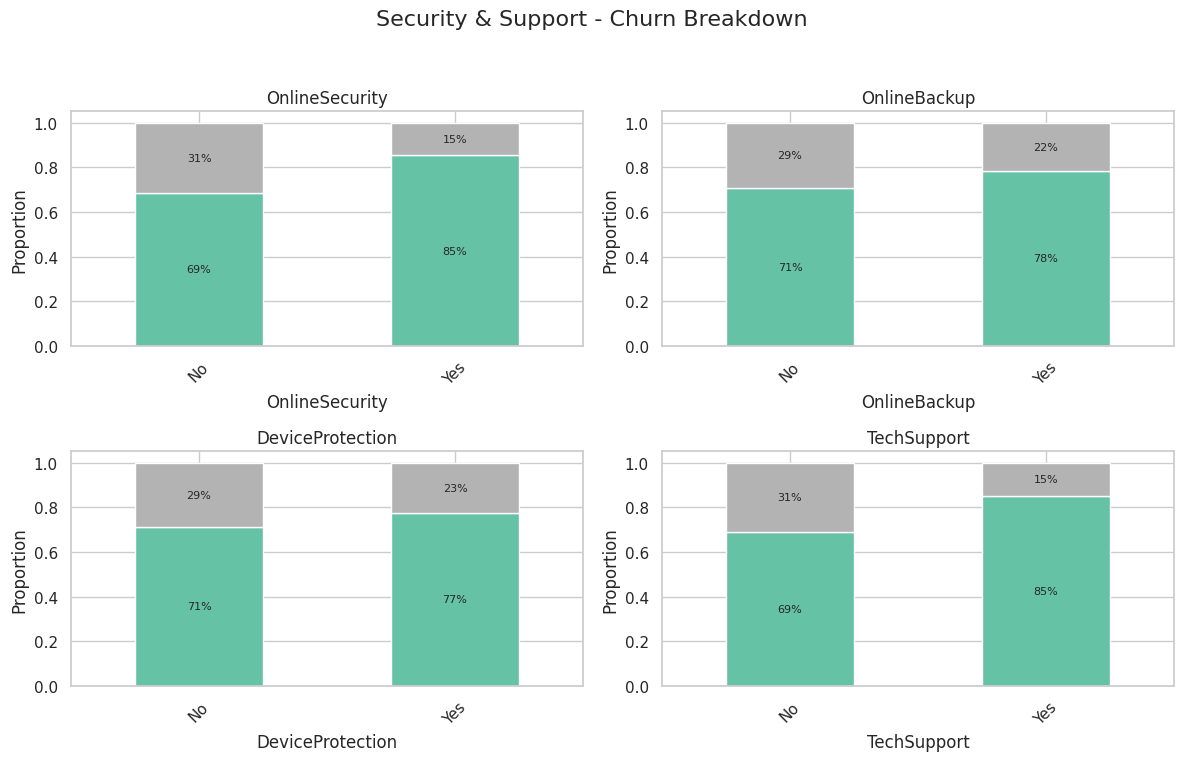

In [42]:
plot_group_churn_stacked("Security & Support", groups["Security & Support"], df)

* Customers without OnlineSecurity, OnlineBackup, DeviceProtection, or Tech Support churn more.
* Summary: Lack of support services is linked to churn.

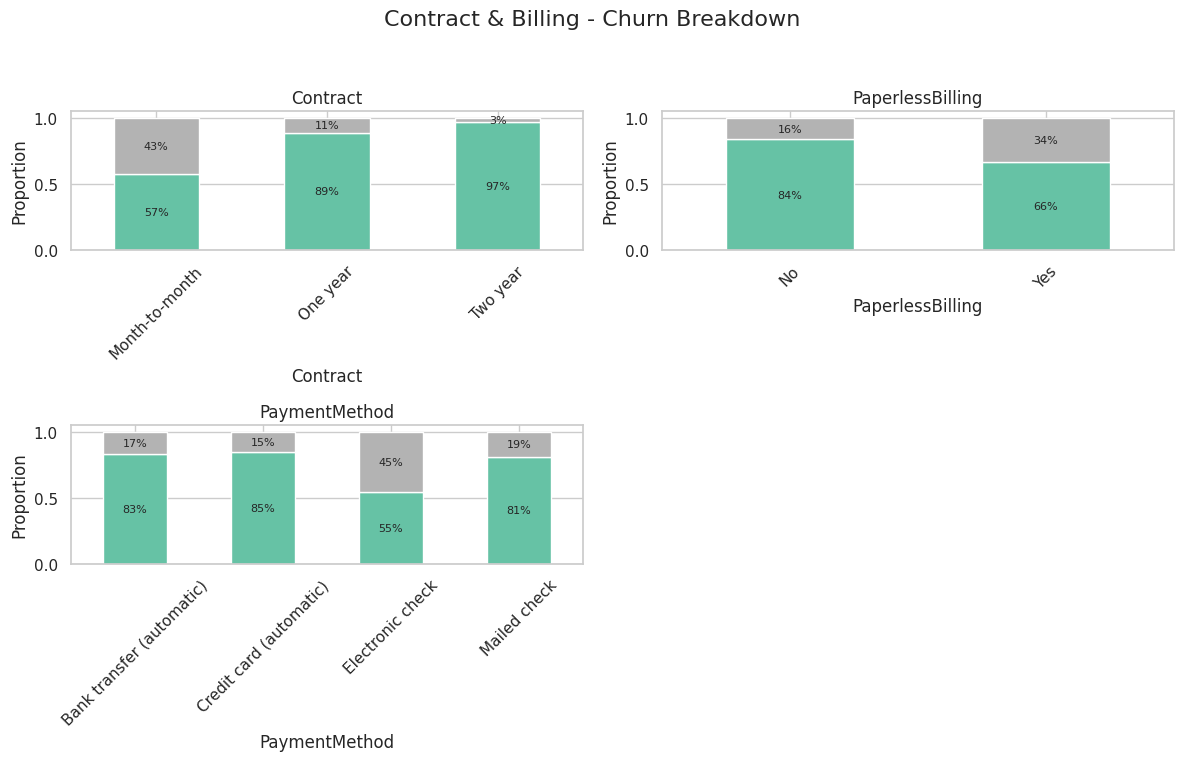

In [43]:
plot_group_churn_stacked("Contract & Billing", groups["Contract & Billing"], df)

* Month-to-month customers churn far more than those on longer-term contracts. These flexible contracts tend to attract low-commitment customers who are more likely to cancel at any time.
* Paperless billing users also show higher churn. This may be due to missed emails or lack of visibility, especially among users who don’t actively manage their accounts online.
* Electronic check users have a much higher churn rate than those using other payment methods. This may be due to manual friction, such as forgotten or delayed payments, which increases churn risk.


### 4.3 Statistical Association with Churn

Apply statistical tests to evaluate which features are significantly associated with the target variable (Churn)

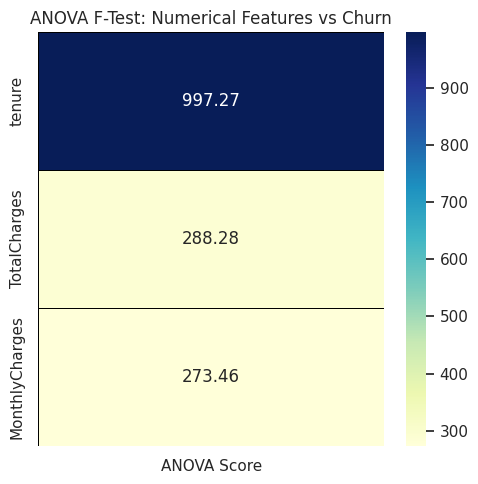

In [44]:
#ANOVA F-Test (Numerical Features)
numerical_cols = ['tenure', 'MonthlyCharges', 'TotalCharges']
features = df[numerical_cols]
target = df['Churn']

# Apply ANOVA F-test
anova_selector = SelectKBest(score_func=f_classif, k='all')
anova_selector.fit(features, target)

# Convert scores to DataFrame
anova_scores = pd.DataFrame(data=anova_selector.scores_,
                            index=features.columns,
                            columns=['ANOVA Score']).round(2)

# Plot heatmap
plt.figure(figsize=(5, 5))
sns.heatmap(anova_scores.sort_values(by='ANOVA Score', ascending=False),
            annot=True, cmap="YlGnBu", linewidths=0.4, linecolor='black', fmt='.2f')
plt.title('ANOVA F-Test: Numerical Features vs Churn')
plt.tight_layout()
plt.show()

* Tenure has the highest F-score (997), making it the strongest numerical predictor of churn.
* TotalCharges and MonthlyCharges also show statistically significant association with churn, though to a lesser degree.

<ipython-input-45-a66cf3f114db>:7: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['Churn'] = df['Churn'].replace({'Yes': 1, 'No': 0})


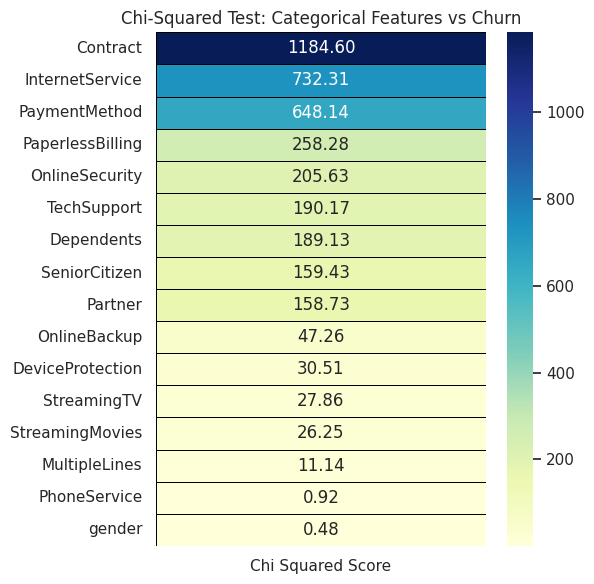

In [45]:
# Chi-Squared Test (Categorical Features)

categorical_cols = df.select_dtypes(include='object').columns.tolist()
categorical_cols.remove('Churn')  # Exclude target

# Convert target to numeric
df['Churn'] = df['Churn'].replace({'Yes': 1, 'No': 0})

# Store scores
chi2_scores = {}

for col in categorical_cols:
    contingency = pd.crosstab(df[col], df['Churn'])
    chi2_stat, p, dof, expected = chi2_contingency(contingency)
    chi2_scores[col] = chi2_stat

# Convert to DataFrame
chi2_df = pd.DataFrame.from_dict(chi2_scores, orient='index', columns=['Chi Squared Score'])
chi2_df = chi2_df.sort_values(by='Chi Squared Score', ascending=False).round(2)

# Plot heatmap
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 6))
sns.heatmap(chi2_df, annot=True, cmap='YlGnBu', linewidths=0.4, linecolor='black', fmt='.2f')
plt.title('Chi-Squared Test: Categorical Features vs Churn')
plt.tight_layout()
plt.show()

* Contract, InternetService, and PaymentMethod are the most influential categorical variables for churn.
* PhoneService and gender show negligible association and can be safely removed from the model.
* These results align well with previous stacked bar chart and EDA findings.

## 5. Feature Selection




In [46]:
df.drop(columns = ['PhoneService', 'gender'],inplace = True)
df.head()

,SeniorCitizen,Partner,Dependents,tenure,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,No,Yes,No,1,No,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,0
1,No,No,No,34,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,0
2,No,No,No,2,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,1
3,No,No,No,45,No,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,0
4,No,No,No,2,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,1


## 6. Label Encoding

In [47]:
# identifying columns with object data type
object_columns = df.select_dtypes(include="object").columns

In [48]:
print(object_columns)

Index(['SeniorCitizen', 'Partner', 'Dependents', 'MultipleLines',
       'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
       'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract',
       'PaperlessBilling', 'PaymentMethod'],
      dtype='object')


In [49]:
# Initialize a dictionary to save the encoders
encoders = {}

# Apply label encoding and print the label-value mapping
for column in object_columns:
    label_encoder = LabelEncoder()
    df[column] = label_encoder.fit_transform(df[column])
    encoders[column] = label_encoder

    # Print label mappings
    print(f"\n🔤 Encoding for column: {column}")
    mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
    for label, value in mapping.items():
        print(f"  {label} → {value}")

# Save the encoders to a pickle file
with open("encoders.pkl", "wb") as f:
    pickle.dump(encoders, f)



🔤 Encoding for column: SeniorCitizen
  No → 0
  Yes → 1

🔤 Encoding for column: Partner
  No → 0
  Yes → 1

🔤 Encoding for column: Dependents
  No → 0
  Yes → 1

🔤 Encoding for column: MultipleLines
  No → 0
  Yes → 1

🔤 Encoding for column: InternetService
  DSL → 0
  Fiber optic → 1
  No → 2

🔤 Encoding for column: OnlineSecurity
  No → 0
  Yes → 1

🔤 Encoding for column: OnlineBackup
  No → 0
  Yes → 1

🔤 Encoding for column: DeviceProtection
  No → 0
  Yes → 1

🔤 Encoding for column: TechSupport
  No → 0
  Yes → 1

🔤 Encoding for column: StreamingTV
  No → 0
  Yes → 1

🔤 Encoding for column: StreamingMovies
  No → 0
  Yes → 1

🔤 Encoding for column: Contract
  Month-to-month → 0
  One year → 1
  Two year → 2

🔤 Encoding for column: PaperlessBilling
  No → 0
  Yes → 1

🔤 Encoding for column: PaymentMethod
  Bank transfer (automatic) → 0
  Credit card (automatic) → 1
  Electronic check → 2
  Mailed check → 3


In [50]:
encoders

{'SeniorCitizen': LabelEncoder(),
 'Partner': LabelEncoder(),
 'Dependents': LabelEncoder(),
 'MultipleLines': LabelEncoder(),
 'InternetService': LabelEncoder(),
 'OnlineSecurity': LabelEncoder(),
 'OnlineBackup': LabelEncoder(),
 'DeviceProtection': LabelEncoder(),
 'TechSupport': LabelEncoder(),
 'StreamingTV': LabelEncoder(),
 'StreamingMovies': LabelEncoder(),
 'Contract': LabelEncoder(),
 'PaperlessBilling': LabelEncoder(),
 'PaymentMethod': LabelEncoder()}

In [51]:
df.head()

,SeniorCitizen,Partner,Dependents,tenure,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,0,1,0,1,0,0,0,1,0,0,0,0,0,1,2,29.85,29.85,0
1,0,0,0,34,0,0,1,0,1,0,0,0,1,0,3,56.95,1889.50,0
2,0,0,0,2,0,0,1,1,0,0,0,0,0,1,3,53.85,108.15,1
3,0,0,0,45,0,0,1,0,1,1,0,0,1,0,0,42.30,1840.75,0
4,0,0,0,2,0,1,0,0,0,0,0,0,0,1,2,70.70,151.65,1


## 7. Splitting data into Training and Test data

In [52]:
# Seperate features and target
X = df.drop(columns=["Churn"])
y = df["Churn"]

In [53]:
# Split into training and test sets (80% train, 20% test), stratified on churn to preserve class ratio
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [54]:
print("Train shape:", X_train.shape)
print("Test shape:", X_test.shape)

Train shape: (5634, 17)
Test shape: (1409, 17)


In [55]:
print(y_train.value_counts(), y_test.value_counts())

Churn
0    4139
1    1495
Name: count, dtype: int64 Churn
0    1035
1     374
Name: count, dtype: int64


## 8. Model Building and Initial Evaluation

### 8.1 Compute Class Weight for Imbalance Handling

In [56]:
# Compute scale_pos_weight for XGBoost and class_weight for others
counter = Counter(y_train)
neg, pos = counter[0], counter[1]
scale_pos_weight = neg / pos
print("Scale pos weight:", round(scale_pos_weight, 2))

Scale pos weight: 2.77


### 8.2 Cross-Validation with Default Hyperparameters



In [57]:
# Define models
models = [
    DecisionTreeClassifier(random_state=42, class_weight='balanced'),
    RandomForestClassifier(random_state=42, class_weight='balanced'),
    XGBClassifier(random_state=42, scale_pos_weight=scale_pos_weight, eval_metric='logloss')
]

model_names = ['Decision Tree', 'Random Forest', 'XGBoost']
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Function to perform 5-fold cross-validation
def compare_models_cross_validation_skf():
    for model, name in zip(models, model_names):
        cv_score = cross_val_score(model, X_train, y_train, cv=skf)
        mean_accuracy = round(np.mean(cv_score) * 100, 2)
        print(f"{name} → CV Scores: {cv_score}, Mean Accuracy: {mean_accuracy}%")
        print("-" * 50)

# Run cross-validation
compare_models_cross_validation_skf()


Decision Tree → CV Scores: [0.7444543  0.73469388 0.75510204 0.75776398 0.74511545], Mean Accuracy: 74.74%
--------------------------------------------------
Random Forest → CV Scores: [0.78615794 0.7755102  0.80212955 0.77994676 0.80373002], Mean Accuracy: 78.95%
--------------------------------------------------
XGBoost → CV Scores: [0.7826087  0.75776398 0.77639752 0.76663709 0.78063943], Mean Accuracy: 77.28%
--------------------------------------------------


* Insights: From 5-fold cross-validation, Random Forest shows the highest accuracy with default parameters.

### 8.3 Model Training and Evaluation

**8.3.1 Decision Tree**

Decision Tree Accuracy: 0.7267565649396736


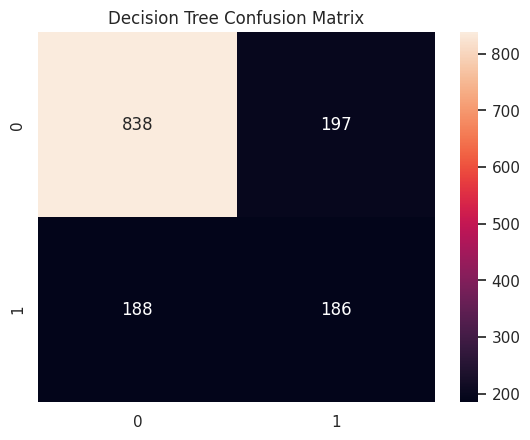

Decision Tree Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.81      0.81      1035
           1       0.49      0.50      0.49       374

    accuracy                           0.73      1409
   macro avg       0.65      0.65      0.65      1409
weighted avg       0.73      0.73      0.73      1409



In [58]:
dtc = DecisionTreeClassifier(random_state=42, class_weight='balanced')
dtc.fit(X_train, y_train)

# Evaluate on test data
y_test_pred = dtc.predict(X_test)

print("Decision Tree Accuracy:", accuracy_score(y_test, y_test_pred))
sns.heatmap(confusion_matrix(y_test, y_test_pred), annot=True, fmt="d")
plt.title("Decision Tree Confusion Matrix")
plt.show()
print("Decision Tree Classification Report:\n", classification_report(y_test, y_test_pred))

* Correctly identified 838 non-churners (TN) and 186 churners (TP).
* Misclassified 197 non-churners as churn (FP), and 188 churners as non-churn (FN).
* Shows **balanced but weaker recall** and lower precision for churned customers compared to XGBoost.


**8.3.2. Random Forest**

Random Forest Accuracy: 0.7849538679914834


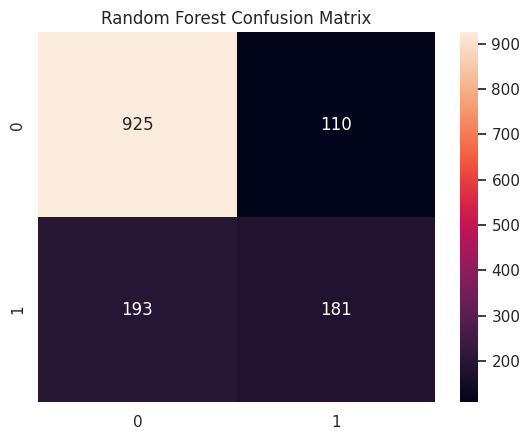

Random Forest Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.89      0.86      1035
           1       0.62      0.48      0.54       374

    accuracy                           0.78      1409
   macro avg       0.72      0.69      0.70      1409
weighted avg       0.77      0.78      0.78      1409



In [59]:
rfc = RandomForestClassifier(random_state=42, class_weight='balanced')
rfc.fit(X_train, y_train)

# Evaluate on test data
y_test_pred = rfc.predict(X_test)

print("Random Forest Accuracy:", accuracy_score(y_test, y_test_pred))
sns.heatmap(confusion_matrix(y_test, y_test_pred), annot=True, fmt="d")
plt.title("Random Forest Confusion Matrix")
plt.show()
print("Random Forest Classification Report:\n", classification_report(y_test, y_test_pred))

* Correctly predicted 925 non-churners (TN) — **highest true negatives**.
* Identified 181 churners (TP), but missed 193 (FN).
* Best **overall accuracy**, but **lowest recall for churn** among the three models.
* May be biased toward majority class (non-churn).

**8.3.3. XGBoost**

XGBoost Accuracy: 0.7579843860894251


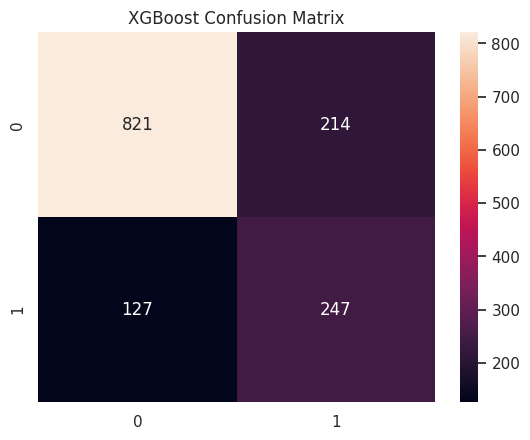

XGBoost Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.79      0.83      1035
           1       0.54      0.66      0.59       374

    accuracy                           0.76      1409
   macro avg       0.70      0.73      0.71      1409
weighted avg       0.78      0.76      0.77      1409



In [60]:
xgbc = XGBClassifier(random_state=42, scale_pos_weight=scale_pos_weight, eval_metric='logloss')
xgbc.fit(X_train, y_train)

# Evaluate on test data
y_test_pred = xgbc.predict(X_test)

print("XGBoost Accuracy:", accuracy_score(y_test, y_test_pred))
sns.heatmap(confusion_matrix(y_test, y_test_pred), annot=True, fmt="d")
plt.title("XGBoost Confusion Matrix")
plt.show()
print("XGBoost Classification Report:\n", classification_report(y_test, y_test_pred))

* Identified 247 churners (TP) — **highest among all models**.
* Misclassified 127 churners as non-churn (FN) * lowest false negatives.
* Higher false positives (214) than others, but **superior recall and F1-score for churn class**.
* Best suited when **detecting churn is more important** than avoiding false positives.

## 9. Hyperparameter Tuning and Selecting Best Model

* Random Forest achieved the highest accuracy and precision, making it better at avoiding false churn predictions, a more cost-effective option when retention resources are limited.

* XGBoost, on the other hand, delivered higher recall and F1-score, making it more effective at identifying actual churners, even if it results in more false positives.

* Both models demonstrated close CV and test accuracy, indicating good generalization and stable performance.

* Therefore, both models were selected for hyperparameter tuning to explore the best trade-off between churn detection performance (recall/F1) and prediction reliability (accuracy/precision).


In [ ]:
# Random Forest hyperparameter grid
param_grid_rfc = {
    'n_estimators': [50, 100, 200, 500],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

# XGBoost hyperparameter grid
param_grid_xgbc = {
    'n_estimators': [50, 100, 200, 500],
    'max_depth': [3, 5, 7, 10],
    'learning_rate': [0.01, 0.1, 0.2, 0.3],
    'subsample': [0.5, 0.7, 1.0]
}

In [ ]:
# RandomizedSearchCV for Random Forest
rfc_random = RandomizedSearchCV(
    estimator=rfc,
    param_distributions=param_grid_rfc,
    n_iter=100,
    cv=5,
    scoring="accuracy",
    random_state=42
)

# RandomizedSearchCV for XGBoost
xgbc_random = RandomizedSearchCV(
    estimator=xgbc,
    param_distributions=param_grid_xgbc,
    n_iter=100,
    cv=5,
    scoring="accuracy",
    random_state=42
)


In [ ]:
#Fit rfc models on training data
rfc_random.fit(X_train, y_train)

RandomizedSearchCV(cv=5,
                   estimator=RandomForestClassifier(class_weight='balanced',
                                                    random_state=42),
                   n_iter=100,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [None, 10, 20, 30],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [50, 100, 200, 500]},
                   random_state=42, scoring='accuracy')

In [ ]:
#Fit the xgbc model on training data
xgbc_random.fit(X_train, y_train)

RandomizedSearchCV(cv=5,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, device=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric='logloss',
                                           feature_types=None, gamma=None,
                                           grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning...
                                           max_leaves=None,
                                           min_child_weight=None, missing=nan,
                                           monotone_constraints=None,
                                           multi_strategy=None,
                                           n_estimators=None, n_jobs=None,
                                           num_parallel_tree=None,
                                           random_state=42, ...),
                   n_iter=100,
                   param_distributions={'learning_rate': [0.01, 0.1, 0.2, 0.3],
                                        'max_depth': [3, 5, 7, 10],
                                        'n_estimators': [50, 100, 200, 500],
                                        'subsample': [0.5, 0.7, 1.0]},
                   random_state=42, scoring='accuracy')

In [ ]:
#Display Best Parameters and Scores
print("Best parameters for Random Forest Classifier:", rfc_random.best_params_)
print("Best score for Random Forest Classifier:", rfc_random.best_score_)
print("Best parameters for XGBoost Classifier:", xgbc_random.best_params_)
print("Best score for XGBoost Classifier:", xgbc_random.best_score_)

Best parameters for Random Forest Classifier: {'n_estimators': 200, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_depth': None, 'bootstrap': True}
Best score for Random Forest Classifier: 0.7900211347184637
Best parameters for XGBoost Classifier: {'subsample': 0.5, 'n_estimators': 200, 'max_depth': 10, 'learning_rate': 0.01}
Best score for XGBoost Classifier: 0.7768862460421655


In [ ]:
#Select the Best Model Based on Cross-Validation Score
best_model = None
best_score = 0

if rfc_random.best_score_ > best_score:
  best_score = rfc_random.best_score_
  best_model = rfc_random.best_estimator_

if xgbc_random.best_score_ > best_score:
  best_score = xgbc_random.best_score_
  best_model = xgbc_random.best_estimator_

In [ ]:
print("Best model:", best_model)
print("Best score:", best_score)

Best model: RandomForestClassifier(class_weight='balanced', min_samples_split=5,
                       n_estimators=200, random_state=42)
Best score: 0.7900211347184637


Best parameters for Random Forest Classifier: {'n_estimators': 200, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_depth': None, 'bootstrap': True}
Best CV score for Random Forest Classifier: 0.79


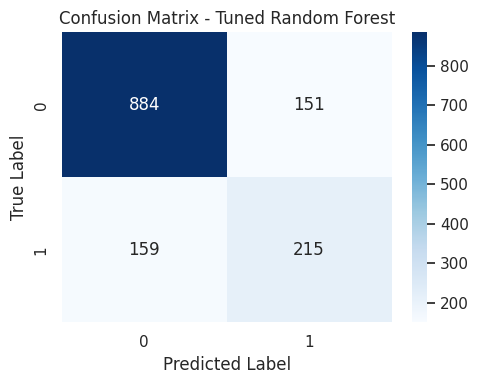

Classification Report for tuned Random Forest:
               precision    recall  f1-score   support

           0       0.85      0.85      0.85      1035
           1       0.59      0.57      0.58       374

    accuracy                           0.78      1409
   macro avg       0.72      0.71      0.72      1409
weighted avg       0.78      0.78      0.78      1409



In [ ]:
# Best parameters and score for Tuned Random Forest Model
print("Best parameters for Random Forest Classifier:", rfc_random.best_params_)
print("Best CV score for Random Forest Classifier:", round(rfc_random.best_score_, 4))

# Predict on test set using the Tuned Random Forest Model
y_pred_best = rfc_random.predict(X_test)

# Confusion Matrix for Tuned Random Forest Model
plt.figure(figsize=(5, 4))
sns.heatmap(confusion_matrix(y_test, y_pred_best), annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix - Tuned Random Forest")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()

# Classification Report for Tuned Random Forest Model
print("Classification Report for tuned Random Forest:\n", classification_report(y_test, y_pred_best))


* Recall improved by 9%, meaning the model now captures more actual churners.

* F1-score also improved, indicating a better balance between precision and recall.

* Precision dropped slightly, but overall the model is more balanced and robust.

* Overall, tuning shifted the model toward better churn detection, without compromising accuracy, making it more useful for real-world deployment.

* Random Forest remains a strong choice when minimizing false churn predictions is a priority. It provides more precise targeting, reducing unnecessary retention costs which is ideal for cost-sensitive strategies.

Best parameters for XGBoost Classifier: {'subsample': 0.5, 'n_estimators': 200, 'max_depth': 10, 'learning_rate': 0.01}
Best CV score for XGBoost Classifier: 0.7769


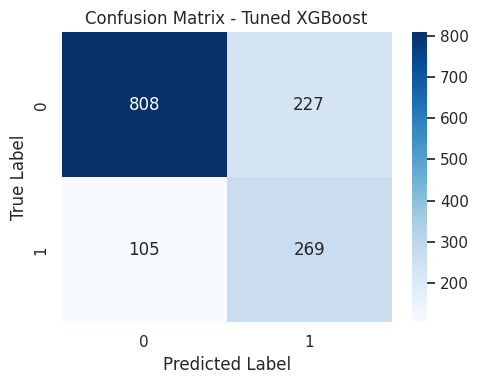

Classification Report for tuned XGBoost:
               precision    recall  f1-score   support

           0       0.88      0.78      0.83      1035
           1       0.54      0.72      0.62       374

    accuracy                           0.76      1409
   macro avg       0.71      0.75      0.72      1409
weighted avg       0.79      0.76      0.77      1409



In [ ]:
# Best parameters and score for the Tuned XGBoost model
print("Best parameters for XGBoost Classifier:", xgbc_random.best_params_)
print("Best CV score for XGBoost Classifier:", round(xgbc_random.best_score_, 4))

# Predict on test set using the Tuned XGBoost model
y_pred_best = xgbc_random.predict(X_test)

# Confusion Matrix
plt.figure(figsize=(5, 4))
sns.heatmap(confusion_matrix(y_test, y_pred_best), annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix - Tuned XGBoost")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()

# Classification Report for the Tuned XGBoost model
print("Classification Report for tuned XGBoost:\n", classification_report(y_test, y_pred_best))


* Recall improved by 6%, capturing even more real churners.

* F1-score also increased, meaning the model is better balanced.

* Precision remained constant, indicating no added noise from tuning.

* Overall, tuning helped XGBoost better detect churners without harming precision or accuracy, making it even more suitable for retention-first business strategies.

* XGBoost continues to be the preferred model when the goal is to catch as many actual churners as possible. It offers high recall, which is crucial for proactive retention, even if it means reaching out to some customers who wouldn’t have churned.

## 10. Predicting using Best Models

In [ ]:
# Save both tuned models and feature names
model_data = {
    "rfc_model": rfc_random.best_estimator_,
    "xgb_model": xgbc_random.best_estimator_,
    "features_names": X.columns.tolist()
}

with open("customer_churn_models.pkl", "wb") as f:
    pickle.dump(model_data, f)


In [ ]:
# Load Models

with open("customer_churn_models.pkl", "rb") as f:
    model_data = pickle.load(f)

rfc_model = model_data["rfc_model"]
xgb_model = model_data["xgb_model"]
feature_names = model_data["features_names"]

In [ ]:
print(rfc_model)

RandomForestClassifier(class_weight='balanced', min_samples_split=5,
                       n_estimators=200, random_state=42)


In [ ]:
print(feature_names)

['SeniorCitizen', 'Partner', 'Dependents', 'tenure', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'MonthlyCharges', 'TotalCharges']


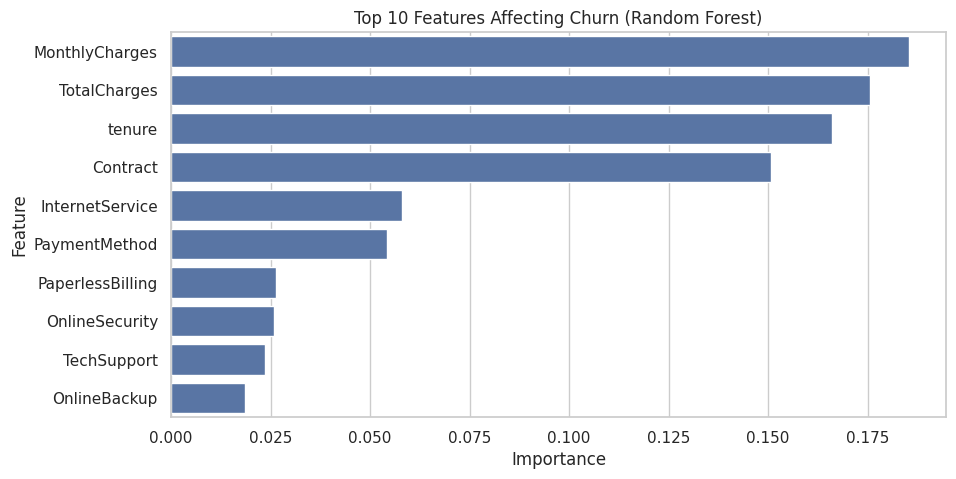

In [ ]:
# RandomForestClassifier- feature importance scores
importances = rfc_model.feature_importances_
features = X_train.columns

# Create a DataFrame and sort by importance
feature_df = pd.DataFrame({'Feature': features, 'Importance': importances})
feature_df = feature_df.sort_values(by='Importance', ascending=False)

# Plot
plt.figure(figsize=(10, 5))
sns.barplot(data=feature_df.head(10), x='Importance', y='Feature')
plt.title("Top 10 Features Affecting Churn (Random Forest)")
plt.show()

* This plot shows that MonthlyCharges, TotalCharges, and tenure are the top contributors to churn prediction. This aligns with our earlier EDA ie. churned customers tend to have higher monthly fees and lower total charges due to short tenure. Contract type also ranks high, reinforcing that short-term contracts are associated with higher churn. Overall, Random Forest distributes importance across multiple features, suggesting that churn is influenced by a combination of billing, contract, and service-related factors.

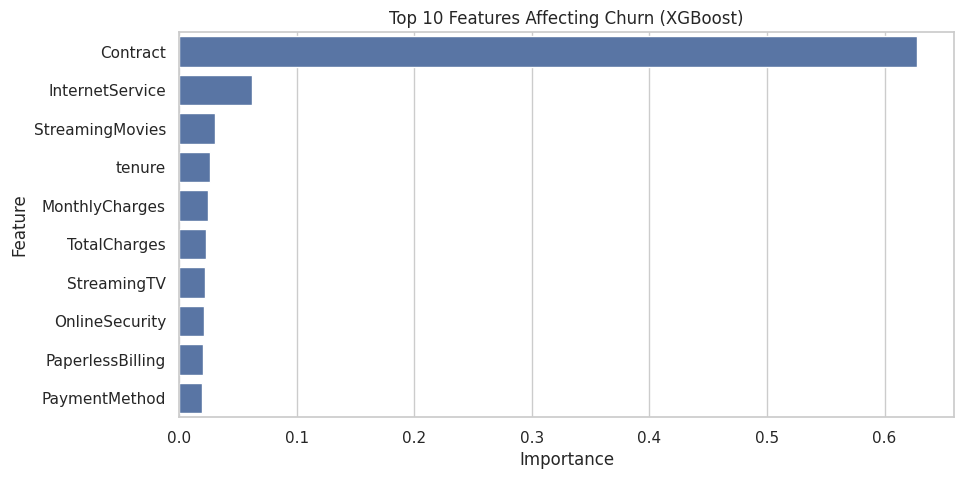

In [ ]:
# XGBoost Classifier- feature importance scores
importances = xgb_model.feature_importances_
features = X_train.columns

# Create a DataFrame and sort by importance
feature_df = pd.DataFrame({'Feature': features, 'Importance': importances})
feature_df = feature_df.sort_values(by='Importance', ascending=False)

# Plot
plt.figure(figsize=(10, 5))
sns.barplot(data=feature_df.head(10), x='Importance', y='Feature')
plt.title("Top 10 Features Affecting Churn (XGBoost)")
plt.show()

XGBoost identifies Contract as by far the most critical feature, followed by InternetService, StreamingMovies, and tenure. This shows XGBoost focuses on contractual commitment and service preferences as the strongest churn indicators. The dominance of Contract indicates that customers on month-to-month plans are far more likely to churn.

In [ ]:
# Prepare Input

input_data = {
    'SeniorCitizen': 'Yes',
    'Partner': 'Yes',
    'Dependents': 'Yes',
    'tenure': 1,
    'MultipleLines': 'No',
    'InternetService': 'DSL',
    'OnlineSecurity': 'No',
    'OnlineBackup': 'Yes',
    'DeviceProtection': 'No',
    'TechSupport': 'No',
    'StreamingTV': 'No',
    'StreamingMovies': 'No',
    'Contract': 'Month-to-month',
    'PaperlessBilling': 'No',
    'PaymentMethod': 'Electronic check',
    'MonthlyCharges': 29.85,
    'TotalCharges': 29.85
}

input_df = pd.DataFrame([input_data])

In [ ]:
# Encode Input Using Saved Encoders
with open("encoders.pkl", "rb") as f:
    encoders = pickle.load(f)

for column, encoder in encoders.items():
    if column in input_df.columns:
        input_df[column] = encoder.transform(input_df[column])

In [ ]:
#Predict Using Both Models
# Random Forest Prediction
rfc_pred = rfc_model.predict(input_df)
rfc_prob = rfc_model.predict_proba(input_df)[0][1]

# XGBoost Prediction
xgb_pred = xgb_model.predict(input_df)
xgb_prob = xgb_model.predict_proba(input_df)[0][1]

print(f"Random Forest → Prediction: {'Churn' if rfc_pred[0] == 1 else 'No Churn'}, Probability: {rfc_prob:.2f}")
print(f" XGBoost       → Prediction: {'Churn' if xgb_pred[0] == 1 else 'No Churn'}, Probability: {xgb_prob:.2f}")


Random Forest → Prediction: Churn, Probability: 0.75
 XGBoost       → Prediction: Churn, Probability: 0.78


In [ ]:
#Decision Logic
if xgb_pred[0] == 1 or rfc_pred[0] == 1:
    print("Likely to Churn — Consider proactive retention")
else:
    print("Unlikely to Churn")

Likely to Churn — Consider proactive retention


**To do:**
3. Log reg --> no
6. GridSearchCV
